In [1]:
#data imports
import pandas as pd
import numpy as np

#data science imports
from sklearn.model_selection import cross_val_score,GridSearchCV,train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.decomposition import NMF,PCA
from sklearn.metrics import accuracy_score, r2_score
import statsmodels.api as sm
from scipy import stats

#plotting imports
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
pd.set_option('display.float_format', lambda x: '%.9f' % x)

#Custom
zscore = lambda x: (x-x.mean())/x.std()
np.random.seed(21)

## Data Joins and Data Frame builds

In [2]:
## Import pre cleaned data
data = pd.read_csv('data/cleansed/data.csv',index_col=0).set_index('uniqueid')
locations = pd.read_csv('data/cleansed/locations.csv')

In [3]:
# join locations data
tidy_data = data.join(locations.set_index('uniqueid')[['geographiclevel','stateabbr','cityname']]).copy()

# Only keep census level data
tidy_data = tidy_data[tidy_data['geographiclevel'] == 'Census Tract']

# Drop uneeded columns
tidy_data = tidy_data.drop(['datavaluetypeid','geographiclevel','stateabbr','cityname'],axis=1).reset_index().set_index('uniqueid')

In [4]:
# Check data 
tidy_data.head()

,populationcount,ACCESS2,ARTHRITIS,BINGE,BPHIGH,BPMED,CANCER,CASTHMA,CHD,CHECKUP,...,KIDNEY,LPA,MAMMOUSE,MHLTH,OBESITY,PAPTEST,PHLTH,SLEEP,STROKE,TEETHLOST
uniqueid,,,,,,,,,,,,,,,,,,,,,
0107000-01073000100,3042.000000000,0.239000000,0.325000000,0.101000000,0.462000000,0.800000000,0.052000000,0.127000000,0.080000000,0.763000000,...,0.036000000,0.423000000,0.742000000,0.188000000,0.467000000,0.760000000,0.196000000,0.504000000,0.055000000,0.302000000
0107000-01073000300,2735.000000000,0.288000000,0.313000000,0.108000000,0.456000000,0.803000000,0.046000000,0.118000000,0.082000000,0.738000000,...,0.038000000,0.437000000,0.740000000,0.185000000,0.470000000,0.732000000,0.202000000,0.494000000,0.057000000,0.333000000
0107000-01073000400,3338.000000000,0.261000000,0.346000000,0.095000000,0.501000000,0.820000000,0.052000000,0.130000000,0.088000000,0.775000000,...,0.040000000,0.449000000,0.736000000,0.191000000,0.488000000,0.728000000,0.211000000,0.525000000,0.065000000,0.360000000
0107000-01073000500,2864.000000000,0.281000000,0.378000000,0.086000000,0.543000000,0.840000000,0.058000000,0.134000000,0.108000000,0.788000000,...,0.048000000,0.471000000,0.732000000,0.194000000,0.499000000,0.708000000,0.231000000,0.526000000,0.082000000,0.402000000
0107000-01073000700,2577.000000000,0.318000000,0.385000000,0.074000000,0.554000000,0.833000000,0.057000000,0.143000000,0.119000000,0.787000000,...,0.057000000,0.508000000,0.705000000,0.216000000,0.528000000,0.676000000,0.258000000,0.541000000,0.096000000,0.458000000


<h2> There are a handful of features that in this data set that either do not make contextual sense for predicting the obesity rate of a population (getting a papsmear/mammogram appears to correlate with obesity) or are already well known effects of having obesity. According to the CDC<sup>1</sup>, High Blood Pressure (BPHIGH), Kidney Disease, CHD, and Arthritis

<p>I'll remove the items typically associated as effects of obesity as well of those that don't make contextual sense</p>

<p><sup>1</sup><a href='https://www.cdc.gov/healthyweight/effects/index.html'>CDC: The Health Effects of Overweight and Obesity</a></p>

In [5]:
# Contextualy irrelevant features
drop_noncontext = np.array(['MAMMOUSE','PAPTEST','BPMED','TEETHLOST','DENTAL']) 

# Effects of obesity
drop_effects_of_obesity = np.array(['CHD','BPHIGH','ARTHRITIS','DIABETES','HIGHCHOL','PHLTH','KIDNEY','STROKE'])

# Drop effects/irrelevant features
tidy_data_less_noncontext_effects = tidy_data.drop(np.concatenate([drop_noncontext,drop_effects_of_obesity]),axis=1)

<h2> First, Let's check for correlation among the features. We'll drop any feature that has a high correlation</h2>

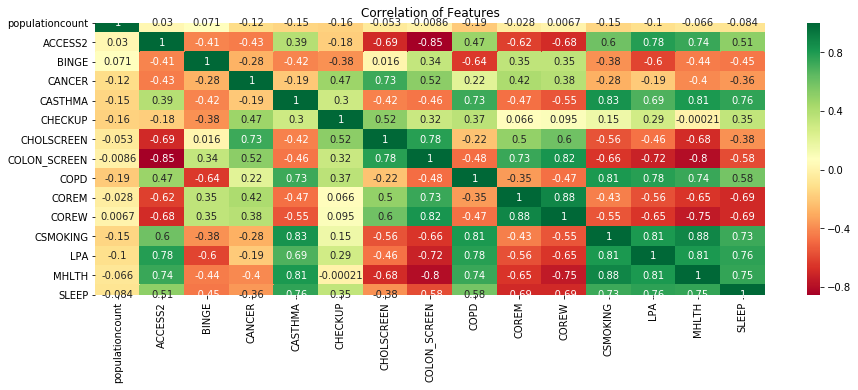

In [6]:
fig,ax = plt.subplots(figsize=(15,5))
sns.heatmap(tidy_data_less_noncontext_effects.drop('OBESITY',axis=1).corr(),annot=True, cmap='RdYlGn')
plt.title('Correlation of Features')
plt.show()

<h2>There are 4 highly positve correlated features. They Include:</h2>
<ul>Mental health & current smoker (.88)</ul>
<ul>COREM & COREW (.88)</ul>
<ul>Colon_Screen & ACCESS2 (-.85)</ul>
<ul>COPD & SMOKING</ul>
<h2>I'll drop Mental Health, COREM, Colon screening, and COPD from the feature set</h2>

In [7]:
tidy_data_less_noncontext_effects.drop(['MHLTH','COREM','COPD','COLON_SCREEN'],axis=1,inplace=True)

<h2>Now that the data is in a tidy format, I'll split the data into a train and test group. The model will be built on the training data and the test data will be held out for a final general fit test</h2>

In [8]:
# Set variables into X and y with y being the target and X being the features.

y = tidy_data_less_noncontext_effects['OBESITY']
X = tidy_data_less_noncontext_effects.drop('OBESITY',axis=1)

# Separate data into train test split
Xtrain, Xtest, ytrain, ytest = train_test_split(X,y,test_size=.25)

<h2> Next, we can fit all the features to our model to see if there are any features we could focus on. My goal is to bring the features down to what explains the model</h2>

In [9]:
m0 = sm.OLS(ytrain,Xtrain).fit()
print(m0.summary())

                                 OLS Regression Results                                
Dep. Variable:                OBESITY   R-squared (uncentered):                   0.987
Model:                            OLS   Adj. R-squared (uncentered):              0.987
Method:                 Least Squares   F-statistic:                          1.401e+05
Date:                Thu, 03 Dec 2020   Prob (F-statistic):                        0.00
Time:                        09:16:18   Log-Likelihood:                          39366.
No. Observations:               20398   AIC:                                 -7.871e+04
Df Residuals:                   20387   BIC:                                 -7.862e+04
Df Model:                          11                                                  
Covariance Type:            nonrobust                                                  
                      coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------

<H2>The results seem fairly clean with an R<sup>2</sup> of .987</H2>
<h2>I'll check the residuals plot and qqplot for any outlier detection</h2>

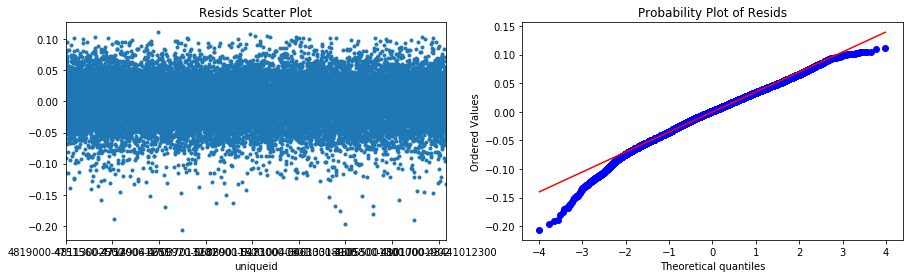

In [10]:
def resid_plots(resid):
    fig,(ax0,ax1) = plt.subplots(1,2,figsize=(15,5))
    _ = resid.plot(marker='.',linestyle='none',figsize=(15,4),ax=ax0,)
    ax0.set_title('Resids Scatter Plot')
    _ = stats.probplot(resid,plot=ax1)
    ax1.set_title('Probability Plot of Resids')
    return fig

resid_plots(m0.resid);

<h2> It looks like there is an abnormal tail to the left of the probability plot, with a handful of residuals that seem like outliers on the bottom end of the scatter plot. I'll try dropping the residual errors of < -.10 and see what that data looks like </h2>

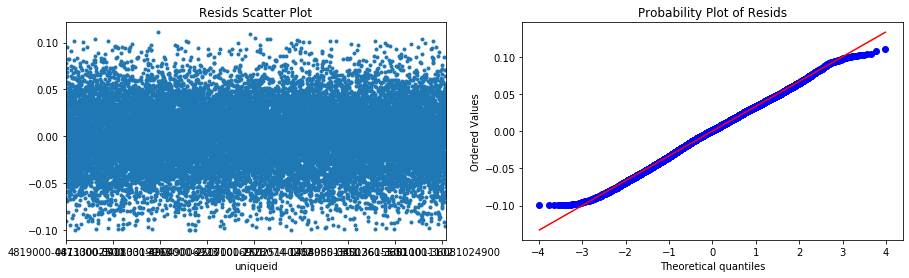

In [11]:
resid_plots(m0.resid[~(m0.resid <= -.10)])
abnormal_resids = m0.resid[m0.resid <= -.10]

<h2>This is a much more normal residual curve and our data probably has some outliers. Next, I'll select these outliers and see how this changes the model</h2>

In [12]:
# init an empty boolean array to store a slicer to select values that are in the outlier residual data set.
arr = np.empty(len(Xtrain.index.values),dtype=np.bool)
for i,j in enumerate(Xtrain.index.values):
    arr[i] = True if j in abnormal_resids.index.values else False

In [13]:
m1 = sm.OLS(ytrain[~arr],Xtrain[~arr]).fit()
print('AIC Change: {:.4f}'.format(m1.aic-m0.aic))
print(m1.summary())

AIC Change: -1336.6065
                                 OLS Regression Results                                
Dep. Variable:                OBESITY   R-squared (uncentered):                   0.988
Model:                            OLS   Adj. R-squared (uncentered):              0.988
Method:                 Least Squares   F-statistic:                          1.539e+05
Date:                Thu, 03 Dec 2020   Prob (F-statistic):                        0.00
Time:                        09:16:21   Log-Likelihood:                          40035.
No. Observations:               20242   AIC:                                 -8.005e+04
Df Residuals:                   20231   BIC:                                 -7.996e+04
Df Model:                          11                                                  
Covariance Type:            nonrobust                                                  
                      coef    std err          t      P>|t|      [0.025      0.975]
-------------

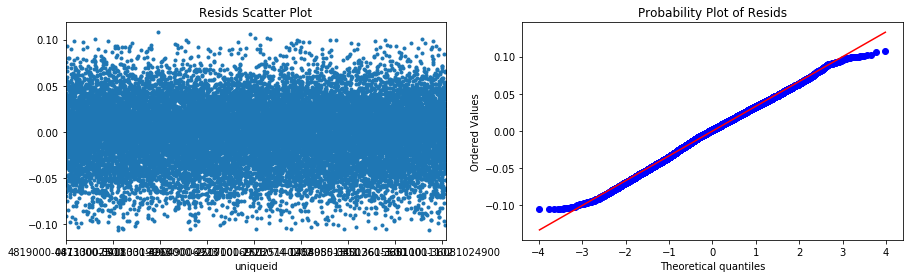

In [14]:
resid_plots(m1.resid);

<h2> Looks like the model AIC score decreases an the R<sup>2</sup> increases just the slightest bit. It looks like removing this data was a good step.</h2>

<h2>Next, I'll sort the correlation coefficients to see if we can start putting together a story</h2>

In [15]:
#Set the alpha for confidence interval sizes
alpha = .05

#Obtain Coefficient confidence intervals
conf_ints = m1.conf_int(alpha=alpha)
conf_ints.columns =['low','high']
conf_ints.sort_values('low',ascending=False)

,low,high
CASTHMA,0.641193275,0.751992613
CSMOKING,0.504944768,0.540993787
LPA,0.285464308,0.320737523
ACCESS2,0.160539792,0.179349859
CHOLSCREEN,0.101238641,0.127024479
COREW,0.034027081,0.056435883
populationcount,-0.000001622,-0.000001139
CHECKUP,-0.007213327,0.023056344
SLEEP,-0.124738157,-0.088470267
BINGE,-0.142903353,-0.113291311


<h4>It seems like features that inhibit exercise are high up on the feature list as predictors of a high obesity rate in local census tracts. If you find populations where they have high % of their constituents with asthma and/or being a current smoker, you'll probably find a high obesity rate. In a not so distant 3rd is reported low phyiscal activity.</h4>

<BR>

<h4>If we think about features that may be indicators of a low rate of obesity, we find populations with higher rates of cancer, binge drinking, and reporting less than 7 hours of sleep a night. I'm not sure why populations with a higher rate of cancer would be a strong predictor of populations with a lower obesity rate. As far as lack of sleep, it may be justified to lose a couple hours in order to get one's physical activity in. The less you sleep, the more you have time for physical activity, the lower a populations obesity rate. As far as binge drinking goes, this could be from a work hard/play hard type of lifestyle. The population may put in a lot of work in dieting/getting physical activity but also will binge drink on their free time</h4>

<H2> Now that I have a model and a story, I'll run these through various SKLEARN libraries such as LinearRegression, Lasso, Ridge, and RandomForestRegressor to see if I get different values. I'll also perform Cross Fold Validation to ensure the model has a good general fit. Finally, I'll test each model on the hold out dat ato see how it performs</H2>

In [16]:
## Define r2 scoring for cross_val_score scoring
def scorer(model,X,y):
    model.fit(X,y)
    ypred = model.predict(X)
    return r2_score(y,ypred)

#INIT Linear Regression
lr = LinearRegression()

#Fit Linear Regression to the training data with outliers withheld
lr.fit(Xtrain[~arr],ytrain[~arr])

#print results
print('Model Accuracy')
print('Linear Regression R2: {:.4f}'.format(lr.score(Xtrain[~arr],ytrain[~arr])))
print('Cross Fold Validation')
print('Linear Regression Cross Val Score: {}'.format(cross_val_score(lr,Xtrain[~arr],ytrain[~arr],cv=5,scoring=scorer)))
pd.DataFrame(lr.coef_,index=Xtrain[~arr].columns,columns=['Coefs']).sort_values('Coefs',ascending=False).sort_values('Coefs',ascending=False)

Model Accuracy
Linear Regression R2: 0.8344
Cross Fold Validation
Linear Regression Cross Val Score: [0.82855239 0.83478279 0.83394659 0.8405201  0.83588151]


,Coefs
CASTHMA,1.191421800
CSMOKING,0.486911806
ACCESS2,0.323054755
LPA,0.236084636
CHOLSCREEN,0.227689364
COREW,0.128596521
BINGE,0.089076092
CHECKUP,0.004142167
populationcount,-0.000000731
SLEEP,-0.006522867


<h2>There are a couple differences from the statsmodels output</h2>
<UL>
<LI>We saw a R<sup>2</sup> decline of about 15% from .988 to .834</LI>
<LI>Asthma and Smoking stayed where they started but lack of access to healthcare flipped positions with Low Physical Activty</LI>
<LI>Binge moved up a few positions in feature importance to being an indicator of higher % obesity in a population (Makes more sense to me)</LI>
<LI>The cross validation performed fairly well and the model is generalized across the data</LI>
</UL>
<H2>Now we'll see how it performs against the holdout data</H2>

In [17]:
print('Linear Regression Holdout Data Score: {:.4f}'.format(r2_score(ytest,lr.predict(Xtest))))

Linear Regression Holdout Data Score: 0.8278


<H2>The test on the holdout data is still solid .83, right in line with the cross validation and the original model itself. This model would be safe to run as is, expecting the results of an R<sup>2</sup> of .83</H2>

<H2> The only way we'd want to change the model is if we can perform with a better score. I'll try building with a Ridge Regression, Lasso, and a random forest</H2>

In [18]:
#filter out warnings for using alpha=0
import warnings
warnings.filterwarnings('ignore')
print('Using GridSearchCV to find the best alpha in a Lasso regression')
alphas = np.linspace(0,1,20)
params = {'alpha':alphas}

lasso = Lasso()
grid = GridSearchCV(lasso,params,cv=5)
grid.fit(Xtrain[~arr],ytrain[~arr])
best_alpha = grid.best_params_['alpha']
best_score = grid.best_score_
print('Best Alpha: {:.4f}'.format(best_alpha))
print('Best Score: {:.4f}'.format(best_score))
warnings.filterwarnings('default')

Using GridSearchCV to find the best alpha in a Lasso regression
Best Alpha: 0.0000
Best Score: 0.8342


<h3>The Lasso regression did not perform any differently the LinearRegression - with an alpha of 0. The holdout test should preform exactly the same as the Linear Regression</h3>

In [19]:
warnings.filterwarnings('ignore')
lasso = Lasso(alpha=best_alpha)
lasso.fit(Xtrain[~arr],ytrain[~arr])
ypred = lasso.predict(Xtrain[~arr])
ypred = lasso.predict(Xtest)
print('Score on holdout data: {:.4f}'.format(r2_score(ytest,ypred)))
warnings.filterwarnings('default')

Score on holdout data: 0.8278


<h3>And it did, as expected</h3>

<h3>Next, I'll use GridSearchCV with Ridge Regression to see if there is an optimum Alpha to obtain a better score</h3>

In [20]:
alphas = np.linspace(0,1,20)
params = {'alpha':alphas}

ridge = Ridge()
grid = GridSearchCV(ridge,params,cv=5)
grid.fit(Xtrain[~arr],ytrain[~arr])
best_alpha = grid.best_params_['alpha']
best_score = grid.best_score_
print('Best Alpha: {:.4f}'.format(best_alpha))
print('Best Score: {:.4f}'.format(best_score))

Best Alpha: 0.0000
Best Score: 0.8342


<h3>This score is identical to that of the the LinearRegression model with no alpha. In fact, when we compare it to the holdout data, we get the same score as on the Linear Regression as well. This is because the best alpha is 0 and is the same as a Linear Regression Model</h3>

In [21]:
print('Ridge Model Tested on Unseen Data')
ridge = Ridge(alpha=best_alpha)
ridge.fit(Xtrain[~arr],ytrain[~arr])
ypred = ridge.predict(Xtest)
print('Score on holdout data: {:.4f}'.format(r2_score(ytest,ypred)))

Ridge Model Tested on Unseen Data
Score on holdout data: 0.8278


<h2>Lastly, let's see how a random forests model fits this data</h2>

In [22]:
from sklearn.ensemble import RandomForestRegressor
randforest= RandomForestRegressor()
randforest.fit(Xtrain[~arr],ytrain[~arr])
ypred = randforest.predict(Xtrain[~arr])
print('Random Forest R^2 Score: {:.4f}'.format(r2_score(ytrain[~arr],ypred)))

/Users/bharathkoneti/opt/anaconda3/lib/python3.7/importlib/_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject
  return f(*args, **kwds)
/Users/bharathkoneti/opt/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


Random Forest R^2 Score: 0.9857


<h4>Our random forests regressor fits the data very well. Let's see how it performs when we generalize it with Cross Validation</h4>

In [23]:
cross_val_score(randforest,Xtrain[~arr],ytrain[~arr],cv=5,scoring=scorer)

array([0.9792289 , 0.97941935, 0.9789055 , 0.98052453, 0.98055628])

<h3> Indeed, the model has generalized the data very well too. </h3>
<h2> Finally, let's see how the random forests performs on the holdout data</h2>

In [24]:
ypred = randforest.predict(Xtest)
print('Random Forst R^2 Score: {:.4f}'.format(r2_score(ytest,ypred)))

Random Forst R^2 Score: 0.9195


<h3>Once again, the random forest performed well on the holdout, although not as well as the cross validation data. We dropped from about .98 to .92. I would say it still has a good fit</h3>

<h3>The random forest can also gives us Feature Importances.</h3>

In [25]:
pd.DataFrame(randforest.feature_importances_,index=Xtrain.columns,columns=['Feature Importances']).sort_values('Feature Importances',ascending=False)

,Feature Importances
LPA,0.611399313
CSMOKING,0.198529303
SLEEP,0.041874381
ACCESS2,0.032887805
CASTHMA,0.023670268
BINGE,0.020559657
CHECKUP,0.019965509
COREW,0.018021239
CHOLSCREEN,0.014246385
CANCER,0.011048485


<h3>The Random Forests fits the data similiarly to the sklearn LinearRegression model with one key difference. Low physical activity ranks highest in feature importance.</h3>